# Model Evaluation

In this notebook, we will test multiple model and evaluate to choose the best one.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pickle

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

pd.set_option('precision', 4)
pd.options.display.max_seq_items = None
pd.options.display.max_columns = 50

In [2]:
# Importing data
X = pd.read_pickle('PKL/X_train.pkl')
y = pd.read_pickle('PKL/Y_train.pkl')

## Train/Test Split
We will split the train data once more. It's because this is a competition dataset and we actually don't have the 'test' score result. So we will use the test set we created from the initial training set as a holdout set to actually see our performance of the final model. The final test set, which we don't have the labels for, will be used to make a prediction in the final testing notebook. 

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 13, test_size = 0.2)

In [4]:
# Turning all categorical features to dummies 
X_train_ohe = pd.get_dummies(X_train)
X_test_ohe = pd.get_dummies(X_test)

In [5]:
# Check if training and testing sets have the same features
if X_train_ohe.shape[1] != X_test_ohe.shape[1]:
    print([x for x in X_train_ohe.columns if x not in X_test_ohe.columns])
    print([x for x in X_test_ohe.columns if x not in X_train_ohe.columns])
else: 
    print ('Good to go')

Good to go


In [6]:
# If they are not the same, add the column with 0s and fix the order
# X_test_ohe[colname] = 0
# X_test_ohe = X_test_ohe[X_train_ohe.columns]

## Class Imbalance Issue
Our dataset has high class imbalance issue. We will mostly deal with this by setting the class weight within each model, otherwise mentioned (in some cases where imbalance weight is not adequately dealt with by algorithm we test with SMOTE).

## Evaluation Metrics
Our target is multi-class with imbalance issue. To focus on the imbalance of minority classes, we will use balanced accuracy score. This computes the average accuracy score weighted by the inverse prevalence of the true class. So it accounts for the imbalance for rigorously then the weighted f1 score, which only takes the number of positive cases into account. We will also look at the weighted f1 score to capture the predictive performance for overall classes. It calculates the f1 score for each class and find the average weighted by the number of actual positive cases in each class, so naturally penalizes if minority recall is low.

In terms of prediction within each class, we rather want to overpredict 'needs repair' or 'non functional' cases (minorities) than the functional cases. Because the condition of the well is crucial for survival of surrounding population. Specifically, we want the recall of the non functional and needs repair cases to be high because false positive of minority classes is better than missing those actually positive classes. I will look at this breakdown using the classification report.

Additionally we will plot confusion matrix to understand some of the scores better.

In [6]:
from sklearn.metrics import f1_score, balanced_accuracy_score, plot_confusion_matrix, classification_report

## Dummy Classifier
We'll first create a dummy classifier as a baseline score.

In [8]:
#keeping score
score_keeper = {}

In [9]:
from sklearn.dummy import DummyClassifier
dummyc = DummyClassifier(strategy = 'stratified') # using the default stratified strategy
dummyc.fit(X_train_ohe, y_train)
y_pred = dummyc.predict(X_test_ohe)

f1_test = round(f1_score(y_test, y_pred, average = 'weighted'), 3)
acc_test = round(balanced_accuracy_score(y_test, y_pred), 3)
print('Test F1 score: ', f1_test, '/ Test Accuracy: ', acc_test)
score_keeper['baseline'] = (f1_test, acc_test)


Test F1 score:  0.444 / Test Accuracy:  0.336


                         precision    recall  f1-score   support

             functional       0.54      0.53      0.54      4822
functional needs repair       0.09      0.08      0.08       678
         non functional       0.38      0.39      0.39      3410

               accuracy                           0.44      8910
              macro avg       0.34      0.34      0.34      8910
           weighted avg       0.44      0.44      0.44      8910



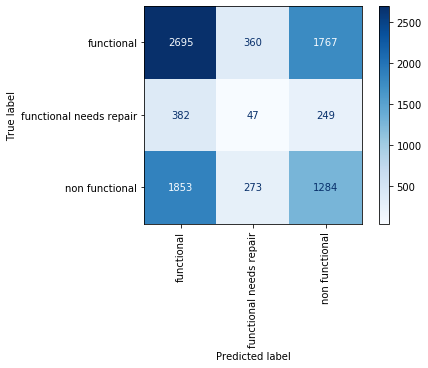

In [10]:
plot_confusion_matrix(dummyc, X_test_ohe, y_test, xticks_rotation = 'vertical', cmap = plt.cm.Blues)
print(classification_report(y_test, y_pred))

Our stratified dummy classifier shows the weighted F1 score around .45 but less balanced accuracy. Dummy classifier is consistently wrong on all cases but recall for minority classes are especially bad.

## KNN
Now we will run K-Nearest Neighbors using GridSearchCV. 

### Standardization
For KNN, all feature values need to be standardized.

In [7]:
from sklearn.preprocessing import StandardScaler

scale = StandardScaler()
X_train_scaled = scale.fit_transform(X_train_ohe)
X_test_scaled = scale.transform(X_test_ohe)

Finding the optimal hyperparameters using GridSearchCV.

In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

In [13]:
params = {
    'n_neighbors': range(1, 16, 2), # setting K
}

knc = KNeighborsClassifier(weights = 'distance') 
knc_g = GridSearchCV(knc, params, cv = 5, scoring = 'balanced_accuracy', verbose = 1, n_jobs = -1)
knc_g.fit(X_train_scaled, y_train)
print(knc_g.best_params_, ': ', knc_g.best_score_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 16.5min finished


{'n_neighbors': 3} :  0.6165279631918787


In [14]:
# saving the model 
#mod = open('PKL/knn_gsc.pkl', 'wb')
#pickle.dump(knc_g.best_estimator_, mod)
#mod.close()

In [15]:
# Reload the model
#knc_g = pickle.load(open('PKL/knn_gsc.pkl', 'rb'))

In [16]:
# KNN performance on the test set
y_pred = knc_g.predict(X_test_scaled)    
f1_test = round(f1_score(y_test, y_pred, average = 'weighted'), 3)
acc_test = round(balanced_accuracy_score(y_test, y_pred), 3)

print('Test F1 score: ', f1_test, '/ Test Accuracy: ', acc_test)
score_keeper['knn_gsc'] = (f1_test, acc_test)
print(classification_report(y_test, y_pred))

Test F1 score:  0.741 / Test Accuracy:  0.622
                         precision    recall  f1-score   support

             functional       0.78      0.81      0.80      4822
functional needs repair       0.39      0.32      0.35       678
         non functional       0.75      0.74      0.74      3410

               accuracy                           0.74      8910
              macro avg       0.64      0.62      0.63      8910
           weighted avg       0.74      0.74      0.74      8910



In [17]:
y_train_pred = knc_g.predict(X_train_scaled)    
f1_test = round(f1_score(y_train, y_train_pred, average = 'weighted'), 3)
f1_test

0.998

Overall improvement from the dummy model, but the recall of needs repair class is still low. Looking at training score (.99) shows that it's highly overfitting. In this document we'll see if different optimization method finds a better hyperparameter. 
In 030B file, we explore more into limiting features using random forest feature selection for KNN as KNN does not select features and can make the model messy. As a summary, after Random Forest feature selection, the performance didn't improve, but also didn't drop. So we know for KNN those extra features were unnecessarily complicating our model. For the sake of keeping it consistent with the rest of models, we will keep all features (they have been already selected based on intuition in the EDA notebook) for now.

### Optimization Method
Now we want to try different optimization method to make sure we have the best hyperparmeter for KNN. This time we'll use optuna to explore even more hyperparameters. We'll cap the time to what it took to run the GridSearch above.

In [9]:
import optuna
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [19]:
def find_hyperp_KNN(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 1, 31)
    algorithm = trial.suggest_categorical('algorithm', ['ball_tree', 'kd_tree'])
    leaf_size = trial.suggest_int('leaf_size', 2, 60)
    p = trial.suggest_categorical('p', [1, 2])
    knc = KNeighborsClassifier(weights = 'distance', 
                             n_neighbors = n_neighbors, 
                             algorithm = algorithm, 
                             leaf_size = leaf_size, 
                             p = p)
    cv = KFold(n_splits = 5, shuffle = True, random_state = 20)
    score = np.mean(cross_val_score(knc, X_train_scaled, y_train, scoring = 'balanced_accuracy', cv = cv, n_jobs = -1))
    return (score)

knn_study = optuna.create_study(direction='maximize')
knn_study.optimize(find_hyperp_KNN, timeout = 16*60)

[I 2020-08-20 11:40:00,703] Trial 0 finished with value: 0.6096783381319073 and parameters: {'n_neighbors': 18, 'algorithm': 'kd_tree', 'leaf_size': 53, 'p': 2}. Best is trial 0 with value: 0.6096783381319073.
[I 2020-08-20 11:44:42,230] Trial 1 finished with value: 0.6188363249223392 and parameters: {'n_neighbors': 30, 'algorithm': 'ball_tree', 'leaf_size': 22, 'p': 1}. Best is trial 1 with value: 0.6188363249223392.
[I 2020-08-20 11:48:14,834] Trial 2 finished with value: 0.6245422567048429 and parameters: {'n_neighbors': 19, 'algorithm': 'kd_tree', 'leaf_size': 23, 'p': 1}. Best is trial 2 with value: 0.6245422567048429.
[I 2020-08-20 11:52:42,863] Trial 3 finished with value: 0.6352037888827585 and parameters: {'n_neighbors': 4, 'algorithm': 'ball_tree', 'leaf_size': 49, 'p': 1}. Best is trial 3 with value: 0.6352037888827585.
[I 2020-08-20 11:57:22,402] Trial 4 finished with value: 0.6245422567048429 and parameters: {'n_neighbors': 19, 'algorithm': 'ball_tree', 'leaf_size': 26, 'p

In [20]:
# saving the study 
#mod = open('PKL/knn_study.pkl', 'wb')
#pickle.dump(knn_study, mod)
#mod.close()

In [21]:
# Reload the study
#knn_study = pickle.load(open('PKL/knn_study.pkl', 'rb'))

In [22]:
# Testing the best params on the test set
knc_opt = KNeighborsClassifier(**knn_study.best_params, weights = 'distance')
knc_opt.fit(X_train_scaled, y_train)

y_pred = knc_opt.predict(X_test_scaled)    
f1_test = round(f1_score(y_test, y_pred, average = 'weighted'), 3)
acc_test = round(balanced_accuracy_score(y_test, y_pred), 3)

print('Test F1 score: ', f1_test, '/ Test Accuracy: ', acc_test)
score_keeper['knn_opt'] = (f1_test, acc_test)
#plot_confusion_matrix(knc_opt, X_test_scaled, y_test, xticks_rotation = 'vertical', cmap = plt.cm.Blues)
print(classification_report(y_test, y_pred))

Test F1 score:  0.753 / Test Accuracy:  0.631
                         precision    recall  f1-score   support

             functional       0.79      0.82      0.81      4822
functional needs repair       0.42      0.32      0.36       678
         non functional       0.76      0.75      0.76      3410

               accuracy                           0.76      8910
              macro avg       0.66      0.63      0.64      8910
           weighted avg       0.75      0.76      0.75      8910



In [61]:
#mod = open('PKL/knc_opt_model.pkl', 'wb')
#pickle.dump(knc_opt, mod)
#mod.close()

Recall score for the needs repair class is still low but the overall performance and recall for non-functional improved slightly.

## Random Forest 
Since Optuna performance was better above, now we'll try running random forest using Optuna. Since we have a lot of features, tree-based model might deal better by ignoring not important features.

In [10]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

In [32]:
def find_hyperparam_rf(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 700)
    max_depth = trial.suggest_int('max_depth', 2, 10)
    #min_samples_split = trial.suggest_int('min_samples_split', 0, 10)
    #min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 15)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    class_weight = trial.suggest_categorical('class_weight', ['balanced', 'balanced_subsample'])
    max_features = trial.suggest_int('max_features', 2, 100)
    rfc = RandomForestClassifier(oob_score = True, 
                             n_estimators = n_estimators, 
                             max_depth = max_depth, 
                             #min_samples_split = min_samples_split, 
                             #min_samples_leaf = min_samples_leaf, 
                             criterion = criterion, 
                             class_weight = class_weight, 
                             max_features = max_features)
    cv = KFold(n_splits = 5, shuffle = True, random_state = 20)
    score = np.mean(cross_val_score(rfc, X_train_ohe, y_train, scoring = 'balanced_accuracy', cv = cv, n_jobs = -1))
    return (score)

#rfc_study = optuna.create_study(direction='maximize')
rfc_study.optimize(find_hyperparam_rf, timeout = 60*60*3) # run it for 3 hours

[I 2020-08-20 13:54:23,185] Trial 2689 finished with value: 0.6706923275206784 and parameters: {'n_estimators': 318, 'max_depth': 9, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'max_features': 25}. Best is trial 2689 with value: 0.6706923275206784.
[I 2020-08-20 13:55:06,902] Trial 2690 finished with value: 0.6714127643076309 and parameters: {'n_estimators': 313, 'max_depth': 9, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'max_features': 26}. Best is trial 2690 with value: 0.6714127643076309.
[I 2020-08-20 13:55:50,525] Trial 2691 finished with value: 0.6705303748728861 and parameters: {'n_estimators': 327, 'max_depth': 9, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'max_features': 25}. Best is trial 2690 with value: 0.6714127643076309.
[I 2020-08-20 13:56:33,946] Trial 2692 finished with value: 0.670188901813268 and parameters: {'n_estimators': 324, 'max_depth': 9, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'max_features': 2

KeyboardInterrupt: 

In [33]:
# save the study
#mod = open('PKL/rfc_study.pkl', 'wb')
#pickle.dump(rfc_study, mod)
#mod.close()

In [ ]:
# Reload the study
#rfc_study = pickle.load(open('PKL/rfc_study.pkl', 'rb'))

In [34]:
rf = RandomForestClassifier(oob_score = True, 
                            **rfc_study.best_params)

rf.fit(X_train_ohe, y_train)
y_pred = rf.predict(X_test_ohe)  

f1_test = round(f1_score(y_test, y_pred, average = 'weighted'), 3)
acc_test = round(balanced_accuracy_score(y_test, y_pred), 3)

print('Test F1 score: ', f1_test, '/ Test Accuracy: ', acc_test)
score_keeper['rf_opt'] = (f1_test, acc_test)

Test F1 score:  0.731 / Test Accuracy:  0.694


In [35]:
#plot_confusion_matrix(rf, X_test_ohe, y_test, xticks_rotation = 'vertical', cmap = plt.cm.Blues)
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.80      0.75      0.77      4822
functional needs repair       0.28      0.66      0.39       678
         non functional       0.83      0.67      0.74      3410

               accuracy                           0.71      8910
              macro avg       0.63      0.69      0.63      8910
           weighted avg       0.77      0.71      0.73      8910



Much better performance in predicting the positive minority cases even though overall F1 score has dropped. This model seems to be weighing the minority recall better. 

In [62]:
#mod = open('PKL/rf_model.pkl', 'wb')
#pickle.dump(rf, mod)
#mod.close()

## XGBoost
Now we'll run XGBoost with Optuna.

In [11]:
import xgboost as xgb

In [43]:
def find_hyperparam(trial):
    eta = trial.suggest_loguniform('eta', 0.001, 0.5)
    max_depth = trial.suggest_int('max_depth', 1, 15)
    #min_child_weight = trial.suggest_int('min_child_weight', 0, 10)
    subsample = trial.suggest_loguniform('subsample', 0.1, 1.0)
    sampling_method = trial.suggest_categorical('sampling_method', ['uniform', 'gradient_based'])
    colsample_bytree = trial.suggest_loguniform('colsample_bytree', 0.1, 1.0)
    xgbc = xgb.XGBClassifier(objective = 'multi:softmax', 
                             eta = eta, 
                             num_boost_round = 999, 
                             early_stopping_rounds=10, 
                             max_depth = max_depth, 
                             #min_child_weight = min_child_weight, 
                             subsample = subsample, 
                             sampling_method = sampling_method, 
                             colsample_bytree = colsample_bytree)
    cv = KFold(n_splits = 5, shuffle = True, random_state = 20)
    score = np.mean(cross_val_score(xgbc, X_train_ohe, y_train, scoring = 'balanced_accuracy', cv = cv, n_jobs = -1))
    return (score)

#xgb_study = optuna.create_study(direction='maximize')
xgb_study.optimize(find_hyperparam, timeout = 60*60)

[I 2020-08-20 17:33:16,847] Trial 35 finished with value: 0.6520639628197994 and parameters: {'eta': 0.0012988334911475854, 'max_depth': 14, 'subsample': 0.5022969261179748, 'sampling_method': 'uniform', 'colsample_bytree': 0.5552048637599156}. Best is trial 31 with value: 0.6571135182900025.
[I 2020-08-20 17:36:37,911] Trial 36 finished with value: 0.6379617145267552 and parameters: {'eta': 0.005506618589988977, 'max_depth': 10, 'subsample': 0.7426994857657646, 'sampling_method': 'uniform', 'colsample_bytree': 0.6534764712400242}. Best is trial 31 with value: 0.6571135182900025.
[I 2020-08-20 17:38:03,222] Trial 37 finished with value: 0.6364513528499576 and parameters: {'eta': 0.0024182275440335532, 'max_depth': 13, 'subsample': 0.6457173136132873, 'sampling_method': 'gradient_based', 'colsample_bytree': 0.16274388139190094}. Best is trial 31 with value: 0.6571135182900025.
[I 2020-08-20 17:39:47,808] Trial 38 finished with value: 0.5642491098417104 and parameters: {'eta': 0.00360655

In [44]:
#Saving study
#mod = open('PKL/xgb_study.pkl', 'wb')
#pickle.dump(xgb_study, mod)
#mod.close()

In [ ]:
# Reload the study
#xgb_study = pickle.load(open('PKL/xgb_study.pkl', 'rb'))

In [45]:
xgbc = xgb.XGBClassifier(**xgb_study.best_params, n_jobs= -1, verbosity=1)

xgbc.fit(X_train_ohe, y_train)

y_pred = xgbc.predict(X_test_ohe)    
f1_test = round(f1_score(y_test, y_pred, average = 'weighted'), 3)
acc_test = round(balanced_accuracy_score(y_test, y_pred), 3)

print('Test F1 score: ', f1_test, '/ Test Accuracy: ', acc_test)
score_keeper['XGB_opt_1'] = (f1_test, acc_test)

Test F1 score:  0.802 / Test Accuracy:  0.664


In [46]:
#plot_confusion_matrix(xgbc, X_test_ohe, y_test, xticks_rotation = 'vertical', cmap = plt.cm.Blues)
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.81      0.89      0.85      4822
functional needs repair       0.59      0.31      0.40       678
         non functional       0.84      0.79      0.81      3410

               accuracy                           0.81      8910
              macro avg       0.75      0.66      0.69      8910
           weighted avg       0.80      0.81      0.80      8910



In [63]:
# saving model
#mod = open('PKL/xgbc_model.pkl', 'wb')
#pickle.dump(xgbc, mod)
#mod.close()

Top two classes are doing so much better, but the minority class recall score dropped significantly. We'll try to oversample minority classes and try again.

## Smote and XGBoost
In order to control for class imbalance in XGBoost, we'll try to oversample using SMOTE.

In [12]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_train_res, y_train_res = smote.fit_sample(X_train_ohe, y_train)

In [65]:
def find_hyperparam2(trial):
    
    eta = trial.suggest_loguniform("eta", 1e-8, 1.0)
    max_depth = trial.suggest_int('max_depth', 1, 10)
    min_child_weight = trial.suggest_int('min_child_weight', 0, 10)
    subsample = trial.suggest_loguniform("subsample", 1e-8, 1.0)
    sampling_method = trial.suggest_categorical('sampling_method', ['uniform', 'gradient_based'])
    colsample_bytree = trial.suggest_loguniform("colsample_bytree", 1e-8, 1.0)
    num_parallel_tree = trial.suggest_int('num_parallel_tree', 1, 10)
    max_delta_step = trial.suggest_int('max_delta_step', 0, 1)
    xgbc = xgb.XGBClassifier(objective = 'multi:softmax', 
                             eta = eta, 
                             num_boost_round = 999, 
                             early_stopping_rounds=10, 
                             max_depth = max_depth, 
                             min_child_weight = min_child_weight, 
                             subsample = subsample, 
                             sampling_method = sampling_method, 
                             colsample_bytree = colsample_bytree, 
                             num_parallel_tree = num_parallel_tree, 
                             max_delta_step = max_delta_step,
                             )
    cv = KFold(n_splits = 5, shuffle = True, random_state = 20)
    score = np.mean(cross_val_score(xgbc, X_train_res, y_train_res, scoring = 'balanced_accuracy', cv = cv, n_jobs = -1))
    return (score)


In [66]:
#xgb_study2 = optuna.create_study(direction='maximize')
xgb_study2.optimize(find_hyperparam2, timeout = 60*60) 

[I 2020-08-20 20:48:25,348] Trial 25 finished with value: 0.6816795334217501 and parameters: {'eta': 1.0888614100546952e-08, 'max_depth': 10, 'min_child_weight': 0, 'subsample': 0.0014302855677198964, 'sampling_method': 'uniform', 'colsample_bytree': 0.9687720546858777}. Best is trial 20 with value: 0.8243185438593988.
[I 2020-08-20 20:51:45,732] Trial 26 finished with value: 0.7684001712683761 and parameters: {'eta': 2.2278725673155052e-08, 'max_depth': 9, 'min_child_weight': 1, 'subsample': 0.010231994439737336, 'sampling_method': 'uniform', 'colsample_bytree': 0.9810484117774854}. Best is trial 20 with value: 0.8243185438593988.
[I 2020-08-20 20:53:01,562] Trial 27 finished with value: 0.7843421718981711 and parameters: {'eta': 1.1329412014478851e-08, 'max_depth': 10, 'min_child_weight': 1, 'subsample': 0.023601978898212635, 'sampling_method': 'uniform', 'colsample_bytree': 0.2436145769144805}. Best is trial 20 with value: 0.8243185438593988.
[I 2020-08-20 20:53:24,208] Trial 28 fin

KeyboardInterrupt: 

In [50]:
# saving study
#mod = open('PKL/xgb_study2.pkl', 'wb')
#pickle.dump(xgb_study2, mod)
#mod.close()

In [ ]:
# Reload the study
#xgb_study2 = pickle.load(open('PKL/xgb_study2.pkl', 'rb'))

In [51]:
xgbc2 = xgb.XGBClassifier(**xgb_study2.best_params, n_jobs= -1, verbosity=1)
xgbc2.fit(X_train_res, y_train_res)

y_pred = xgbc2.predict(X_test_ohe)    
f1_test = round(f1_score(y_test, y_pred, average = 'weighted'), 3)
acc_test = round(balanced_accuracy_score(y_test, y_pred), 3)

print('Test F1 score: ', f1_test, '/ Test Accuracy: ', acc_test)
score_keeper['XGB_opt_2'] = (f1_test, acc_test)
print(classification_report(y_test, y_pred))

Test F1 score:  0.779 / Test Accuracy:  0.687
                         precision    recall  f1-score   support

             functional       0.80      0.84      0.82      4822
functional needs repair       0.41      0.47      0.44       678
         non functional       0.83      0.75      0.79      3410

               accuracy                           0.78      8910
              macro avg       0.68      0.69      0.68      8910
           weighted avg       0.78      0.78      0.78      8910



There is definitely an improvement with the minority class prediction.

In [64]:
# saving model
#mod = open('PKL/xgbc_model_smote.pkl', 'wb')
#pickle.dump(xgbc2, mod)
#mod.close()

In [54]:
#optuna.visualization.plot_optimization_history(xgb_study)
#optuna.visualization.plot_optimization_history(xgb_study2)

## Voting Classifier
Now I will try to run a voting classifier using the above methods.Since only random forest did well in predicting minority class without oversampling. I will use oversampled data for voting.

In [13]:
xgbc = xgb.XGBClassifier(colsample_bytree=0.8626151873679676, eta=0.001038709382469881,
              max_depth=15, objective='multi:softprob',
              sampling_method='gradient_based', subsample=0.6665960477032411)
xgbc2 = xgb.XGBClassifier(colsample_bytree=0.996, eta=1.0035409883128274e-05,
              max_delta_step=1, max_depth=9, min_child_weight=0,
              num_parallel_tree=7, objective='multi:softprob',
              sampling_method='uniform', subsample=0.0723008974366997)
rf = RandomForestClassifier(class_weight='balanced_subsample', max_depth=10, max_features=34, n_estimators=365, oob_score=True)
knc_opt = KNeighborsClassifier(algorithm='ball_tree', leaf_size=49, n_neighbors=4, p=1, weights='distance')
knc_g = KNeighborsClassifier(n_neighbors=3, weights='distance')
dtcSimple = DecisionTreeClassifier(class_weight='balanced', max_depth=20)
knnOptuna = KNeighborsClassifier(algorithm='kd_tree', leaf_size=6, n_neighbors=2, p=1)
knnSimple = KNeighborsClassifier()
rfc_Optuna = RandomForestClassifier(class_weight='balanced', max_depth=10, max_features=0.066, n_estimators=572)
rfcSimple = RandomForestClassifier(class_weight='balanced_subsample', max_depth=3, max_features=0.3, n_estimators=500)

In [14]:
# standardizing
X_train_scaled = scale.fit_transform(X_train_res)
X_test_scaled = scale.transform(X_test_ohe)

In [15]:
from sklearn.ensemble import VotingClassifier

voting_c_all = VotingClassifier(estimators = [('xgbc', xgbc), 
                                          ('xgbc2', xgbc2), 
                                          ('rf', rf),
                                          ('knc_opt', knc_opt),
                                          ('knc_g', knc_g),
                                          ('dtcSimple', dtcSimple),
                                          ('knnOptuna', knnOptuna),
                                          ('knnSimple', knnSimple),
                                          ('rfc_Optuna', rfc_Optuna),
                                          ('rfcSimple', rfcSimple),
                                         ], 
                            voting = 'soft', 
                           n_jobs = -1, verbose = True)
voting_c_all.fit(X_train_scaled, y_train_res)

C:\Users\Eunjoo\anaconda3\lib\site-packages\joblib\disk.py:122: UserWarning: Unable to delete folder C:\Users\Eunjoo\AppData\Local\Temp\joblib_memmapping_folder_13352_5453397899 after 5 tentatives.
  .format(folder_path, RM_SUBDIRS_N_RETRY))


PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\Eunjoo\\AppData\\Local\\Temp\\joblib_memmapping_folder_13352_5453397899\\13352-2747511024584-06f2885557d548f6bd53e6e4402da8ea.pkl'

In [ ]:
y_pred = voting_c_all.predict(X_test_scaled)    
f1_test = round(f1_score(y_test, y_pred, average = 'weighted'), 3)
acc_test = round(balanced_accuracy_score(y_test, y_pred), 3)

print('Test F1 score: ', f1_test, '/ Test Accuracy: ', acc_test)
score_keeper['voting_equal_soft'] = (f1_test, acc_test)
print(classification_report(y_test, y_pred))

In [56]:
mod = open('PKL/voting_equal.pkl', 'wb')
pickle.dump(voting_c, mod)
mod.close()

In [57]:
y_pred = voting_c.predict(X_test_ohe)    
f1_test = round(f1_score(y_test, y_pred, average = 'weighted'), 3)
acc_test = round(balanced_accuracy_score(y_test, y_pred), 3)

print('Test F1 score: ', f1_test, '/ Test Accuracy: ', acc_test)
score_keeper['voting_equal_soft'] = (f1_test, acc_test)
print(classification_report(y_test, y_pred))

Test F1 score:  0.765 / Test Accuracy:  0.677
                         precision    recall  f1-score   support

             functional       0.81      0.80      0.81      4822
functional needs repair       0.37      0.47      0.41       678
         non functional       0.79      0.76      0.78      3410

               accuracy                           0.76      8910
              macro avg       0.66      0.68      0.67      8910
           weighted avg       0.77      0.76      0.77      8910



In [18]:
from sklearn.linear_model import Lasso, LogisticRegression

In [19]:
LogRegLasso = LogisticRegression(penalty = 'l1', 
                                 tol = 0.0001, 
                                 C = 1, 
                                 solver='liblinear', 
                                 class_weight = 'balanced', 
                                 max_iter = 300)

In [21]:
def scoring(y_test, y_pred):
    f1_test = round(f1_score(y_test, y_pred, average = 'weighted'), 3)
    acc_test = round(balanced_accuracy_score(y_test, y_pred), 3)
    print('Test F1 score: ', f1_test, '/ Test Accuracy: ', acc_test)

In [23]:
#LogRegLasso.fit(X_train_scaled, y_train_res)
#y_pred_lasso = LogRegLasso.predict(X_test_scaled)
scoring(y_test, y_pred_lasso)
print(classification_report(y_test, y_pred_lasso))

Test F1 score:  0.736 / Test Accuracy:  0.62
                         precision    recall  f1-score   support

             functional       0.77      0.82      0.79      4822
functional needs repair       0.31      0.35      0.33       678
         non functional       0.78      0.69      0.73      3410

               accuracy                           0.73      8910
              macro avg       0.62      0.62      0.62      8910
           weighted avg       0.74      0.73      0.74      8910



In [24]:
# saving model
mod = open('PKL/LogRegLasso.pkl', 'wb')
pickle.dump(LogRegLasso, mod)
mod.close()